In [20]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import load_iris

# Загрузим датасет и проверим его содержимое

In [4]:
iris = load_iris(as_frame=True)

In [5]:
df = iris.frame

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [7]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


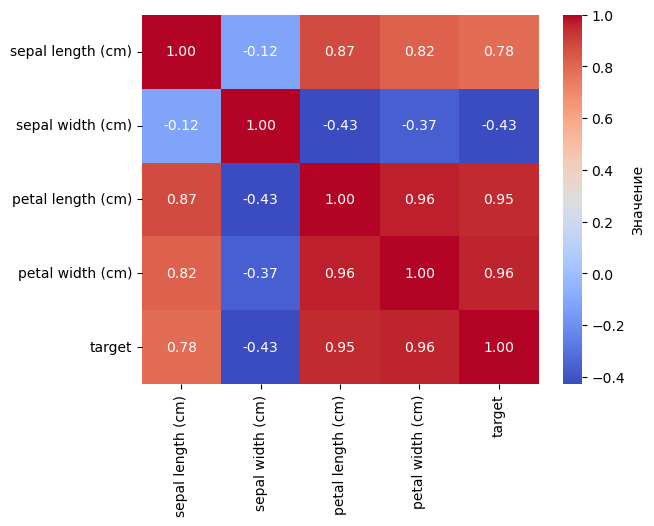

In [9]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Значение'})
plt.show()

# В качестве целевого столбца будем использова столбец target (который имет 3 значения: 0, 1, 2). Это категорийные значения, т.е от нас требуется сделать классификацию поэтому воспользуемся логистической регрессией

In [23]:
import numpy as np

def sigmoid(z):
    """Сигмоидная функция"""
    return 1 / (1 + np.exp(-z))

def logistic_regression_gd(X, y, lr=0.1, lambda_decay=0.01, iterations=1000):
    """
    Логистическая регрессия с градиентным спуском и адаптивным шагом обучения.

    Параметры:
    X - матрица фичей (numpy array), размерность (n_samples, n_features)
    y - вектор пердсказаний, размерность (n_samples,)
    lr - базовый шаг обучения
    lambda_decay - коэффициент адаптивного уменьшения шага
    iterations - количество итераций

    Возвращает:
    w - вектор весов (коэффициентов) модели
    b - смещение (intercept)
    """
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    f1_history = []  # Список для сохранения F1-метрики

    for k in range(1, iterations + 1):
        # Предсказания (вероятности для класса 1)
        z = np.dot(X, w) + b
        y_pred = sigmoid(z)
        
        # Преобразуем вероятности в бинарные предсказания (0 или 1)
        y_pred_class = (y_pred >= 0.5).astype(int)
        
        # Рассчитываем F1-метрику
        f1 = f1_score(y, y_pred_class)
        f1_history.append(f1)
        
        # Градиенты
        error = y_pred - y
        dw = (1 / n_samples) * np.dot(X.T, error)  # Градиент по w
        db = (1 / n_samples) * np.sum(error)       # Градиент по b

        # Адаптивный шаг обучения
        grad_norm = np.linalg.norm(dw) + abs(db)
        alpha = lr / (1 + lambda_decay * k)

        # Обновление параметров
        w -= alpha * dw
        b -= alpha * db

    return w, b, f1_history

def one_vs_rest(X_train, y_train, X_test, y_test, classes, lr=0.1, lambda_decay=0.01, iterations=1000):
    """
    Функция для реализации классификации One-vs-Rest.

    Параметры:
    X - матрица фичей (numpy array)размерность (n_samples, n_features) X_train - тренироваочная, X_test - тестовая
    y - вектор пердсказаний, размерность (n_samples,)  y_train - тренироваочная, y_test - тестовая
    classes - классы для классификации
    lr - базовый шаг обучения
    lambda_decay - коэффициент адаптивного уменьшения шага
    iterations - количество итераций

    Возвращает:
    w - вектор весов (коэффициентов) модели
    b - смещение (intercept)
    """
    all_weights = []  # список для весов
    all_biases = [] # список для смещений
    all_f1_histories = [] # список для f1

    # Для каждого класса создаем бинарные метки и обучаем бинарный классификатор
    for class_label in classes:
        # Преобразуем целевую переменную в бинарную для текущего класса
        y_binary = (y_train == class_label).astype(int)
        
        # Обучаем модель
        w, b, f1_history = logistic_regression_gd(X_train, y_binary, lr, lambda_decay, iterations)
        
        # Сохраняем веса, смещение и историю F1-метрики
        all_weights.append(w)
        all_biases.append(b)
        all_f1_histories.append(f1_history)

    # После обучения классификаторов, делаем предсказания
    y_pred_all_classes = np.zeros((X_test.shape[0], len(classes))) # X_test.shape[0] - колво строк(samle) len(classes) - кол-во фич
    
    for i, class_label in enumerate(classes):
        y_pred_prob = sigmoid(np.dot(X_test, all_weights[i]) + all_biases[i])
        y_pred_all_classes[:, i] = y_pred_prob
    
    # Предсказание будет классом с наибольшей вероятностью
    y_pred = np.argmax(y_pred_all_classes, axis=1)
    
    # Оценка точности и F1 для многоклассовой задачи
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return y_pred, f1, all_f1_histories


In [15]:
X = df.drop(columns=["target"])
y = df["target"] 

# Разбиваем на 80% тренировочных и 20% тестовых данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Классы для классификации
classes = np.unique(y)

# Обучаем модель One-vs-Rest
y_pred, f1, f1_histories = one_vs_rest(X_train, y_train, X_test, y_test, classes, lr=0.1, lambda_decay=0.01, iterations=1000)

In [19]:
print(f"y_pred: {y_pred}")
print(f"f1: {f1}")

y_pred: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0]
f1: 1.0


In [21]:
# Сравниваем предсказания с истинными значениями
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.0
Confusion Matrix:
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



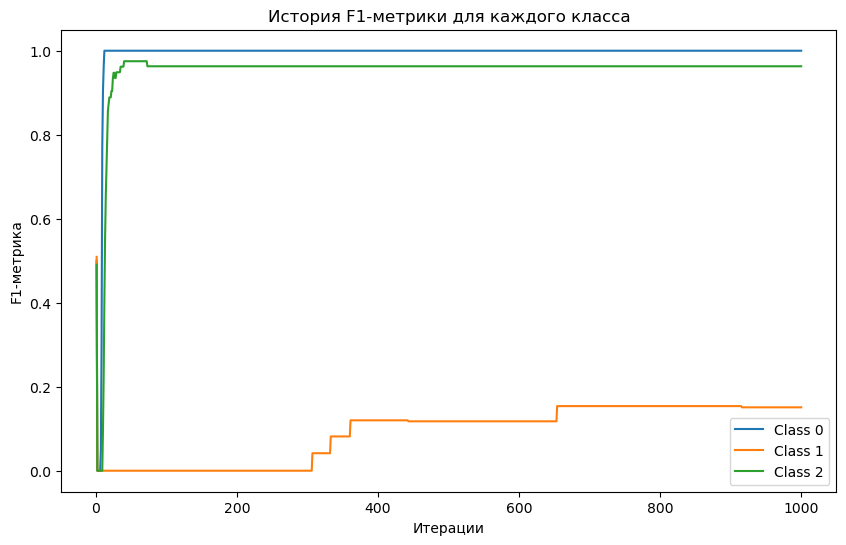

In [22]:
plt.figure(figsize=(10, 6))

# Для каждого классификатора (класса) отобразим его историю F1
for i, f1_history in enumerate(f1_histories):
    plt.plot(range(1, len(f1_history) + 1), f1_history, label=f"Class {classes[i]}")

plt.xlabel("Итерации")
plt.ylabel("F1-метрика")
plt.title("История F1-метрики для каждого класса")
plt.legend()
plt.show()

### Вывод: Мы получили Accuracy - 1, а все данные в датасете геометрия самого цветка, т.е данные однородные, поэтому нормирование как в задании 1 не будет иметь особого смысла.